## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
#to run the summary of the model regression 
# I used the below two lines to create my own chisqprob function since it was removed from the library. 
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
#import the file
df = pd.read_csv("ab_data.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'ab_data.csv'

In [ ]:
#read the first five rows
df.head()

b. Use the cell below to find the number of rows in the dataset.

In [4]:
#number of rows and columns
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df["user_id"].nunique()

290584

d. The proportion of users converted.

In [6]:
df["converted"].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
# to get a count of unique values for group column
df.group.value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

In [8]:
# to get a count of unique values for landing_page column
df.landing_page.value_counts()

old_page    147239
new_page    147239
Name: landing_page, dtype: int64

In [9]:
#filtring 
x = df.query("group == 'treatment' and landing_page == 'old_page'").shape[0]
y = df.query("group == 'control' and landing_page == 'new_page'").shape[0]
x + y 

3893

f. Do any of the rows have missing values?

In [10]:
#searching for missing values
df.isnull().sum().any()

False

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [11]:
#copy from df save it in df2
df2 = df.copy()

In [12]:
#check df2
df2.shape

(294478, 5)

In [13]:
#drop from df2 
df2.drop(df.query(" group == 'treatment' and landing_page == 'old_page' or group == 'control' and landing_page == 'new_page' ").index, inplace=True)

In [14]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [15]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [16]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [17]:
df2["user_id"].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [18]:
df2[df2["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [19]:
df2[df2["user_id"] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [20]:
df2.drop_duplicates(["user_id"] , inplace=True)

In [21]:
#check if one of them is removed 
df2[df2["user_id"] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [22]:
df2["converted"].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [23]:
df2[df2["group"] == "control"]["converted"].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [24]:
df2[df2["group"] == "treatment"]["converted"].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [25]:
#number of rows with new_page
len_new_page = len(df2.query("landing_page == 'new_page'"))

In [26]:
#total number of rows
total = df2.shape[0]

In [27]:
#probability that an individual received the new page
len_new_page / total

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**The new treatment page leads to lower conversions than the old page , although the difference between them is very low as the proportion where individual in control group and converted is 12% , and  proportion where individual in treatment group and converted is 11.8%, seems to be negligible.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Ho = p_new <= p_old**

**H1 = p_new > P_old**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [28]:
#conversion rate for  𝑝𝑛𝑒𝑤  under the null
p_new = df2["converted"].mean()


In [29]:
#print the rate
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [30]:
#conversion rate for  𝑝𝑜𝑙𝑑  under the null will be the same for pnew
p_old = df2["converted"].mean()

In [31]:
#print p_old rate
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [32]:
#to see the columns names
df2.head(1)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


In [33]:
#filter with new page and take the len by shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

In [34]:
#print the number of individuals in the treatment group
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [35]:
#filter with old page and take the len by shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]

In [36]:
##print the number of individuals in the treatment group
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [37]:
#draw the sample from binomial distribution 
new_page_converted = np.random.choice([0,1] , size = n_new , p=[p_new,1-p_new] ,replace=True)

In [38]:
#print 
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

In [39]:
#get the mean from the stimulation for the new page
new_page_converted_mean= new_page_converted.mean()
new_page_converted_mean

0.88000825820659279

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [40]:
#draw the sample from binomial distribution 
old_page_converted = np.random.choice([0,1] , size = n_old , p=[p_old,1-p_old] ,replace=True)

In [41]:
old_page_converted

array([1, 1, 1, ..., 1, 1, 1])

In [42]:
#get the mean from the stimulation for the old page
old_page_converted_mean = old_page_converted.mean()
old_page_converted_mean

0.88049478915704116

**The average of the new page converted and the old page converted are almost same**

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [43]:
#the difference between new page and old page
diff = new_page_converted_mean - old_page_converted_mean
diff

-0.00048653095044837169

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [44]:
p_diffs = []
for i in range(10000):
 
    new_page_converted = np.random.choice([1,0], size = n_new, p = (p_new, 1-p_new) , replace = True)
    old_page_converted = np.random.choice([1,0], size = n_old, p = (p_old, 1-p_old) , replace = True)
    p_diff = (new_page_converted.mean()) - (old_page_converted.mean())
    p_diffs.append(p_diff)
    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

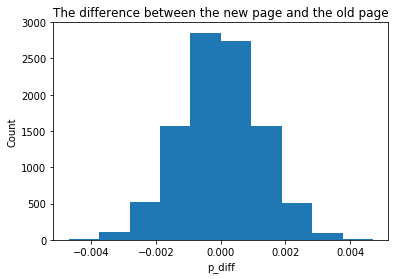

In [45]:
#plot p_diffs
plt.hist(p_diffs);
plt.xlabel('p_diff')
plt.ylabel('Count')
plt.title('The difference between the new page and the old page');

**looks like normal distribution**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [46]:
#The mean of the difference from the  sample
np.mean(p_diffs)

-6.7018611624577286e-06

In [47]:
#The mean of the actual data
actual_data = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()


In [48]:
actual_data

-0.0015782389853555567

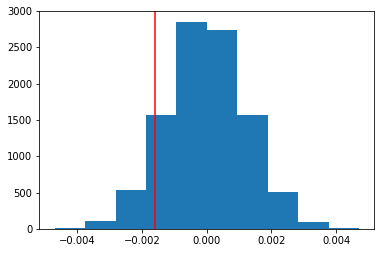

In [49]:
#plot the null and the observed statistics
plt.hist(p_diffs);
plt.axvline(actual_data, color='r');

**Normal Distribution**

In [50]:
#to find the p-value
(p_diffs > actual_data).mean()

0.89929999999999999

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?



**A p-value is a measure of the probability that an observed difference could have occurred just by random chance. The lower the p-value, the greater the statistical significance of the observed difference. P-value can be used as an alternative to or in addition to pre-selected confidence levels for hypothesis testing.**

**The p-value here is 0.9 which is greater than alpha(0.05), that means we can't reject the null hypothesis.**

**According to the null hypothesis p_new <= p_old. Also referring to the conversion rates in part 1 the difference between the two pages is negligible.**



l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [51]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page'")["converted"].sum()
convert_new = df2.query("landing_page == 'new_page'")["converted"].sum()
n_old = len(df2.query("landing_page == 'old_page'"))
n_new = len(df2.query("landing_page == 'new_page'"))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [52]:
sm.stats.proportions_ztest([convert_old , convert_new] , [n_old , n_new] , alternative = "smaller")

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**A Z-score is a numerical measurement that describes a value's relationship to the mean of a group of values. Z-score is measured in terms of standard deviations from the mean. If the value of z is greater than 1.96 or less than -1.96, the null hypothesis is rejected.**

**Z-score in our experement describes that the difference between the conversion rates and the null hypothesis is 1.3 which means we can't reject the null hypothesis. Also the p-value here equal to the above p-value.**

**Conclusion: The z-score test agree with the previous findings.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression since it is a regression approach use to predict one of two possible outcomes.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [53]:
#create the dummies
df2["ab_page"] = pd.get_dummies(df2['group'])['treatment']


In [54]:
#add the intercept
df2["intercept"]=1

In [55]:
#be sure that the intercept and the dummy were added
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [56]:
#fit the logistic regression model 
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [57]:
#provide the summary from the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Mar 2021   Pseudo R-squ.:               8.077e-06
Time:                        18:21:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value for the ab_page is 0.19 , which is greater then aplha (0.05) which indicates that we cannot reject the null hypothesis.**

**In the regression model we assume that the null hypotheses where there is no difference between the treatment group and the control group (in other words p_new = p_old) , and the alternative hypotheses when there is difference between them.**
**In part II  assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.**

**ALso the logistic regression agrees with the hypotheses and probabilities tests.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Tell now it seems that the group (treatment and control ) doesn't help to whether to implement the new page or keep the old page as the difference between them is very low so it is better to consider other factors.**

**multicollinearity may accour if we add other variables to the regression model.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [58]:
#import countries file
df3 = pd.read_csv("countries.csv")

In [59]:
#read the file
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [60]:
#count the countries 
df3["country"].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [61]:
#see df2 head
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


In [62]:
#join df3 with df2 refernce to the "user_id "
df2 = df2.join(df3.set_index('user_id'), on='user_id')


In [63]:
#check df2 head
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [64]:
#check the country value counts after joining 
df2["country"].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [65]:
#create the dummy
df2[["US" , "UK" , "CA"]] = pd.get_dummies(df2['country'])

In [66]:
#check the new columns
df2.head()


,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,US,UK,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1


In [67]:
# fit the regression model(will use CA as the basline as it has the lower users)
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'US', 'UK']])
results = log_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [68]:
#show the summary of the fit 
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 24 Mar 2021   Pseudo R-squ.:               2.323e-05
Time:                        18:21:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**1- The ab_page, US ,  and UK are not statistically significant because there p-value (0.191 , 0.130 , 0.457) are greater than the  significance level of 0.05.**

**2- Based on our predicted values ab_page has negative regression coefficients: for every decrease  the conversion rate by 1.49 will accours (assume all other variables are constant).**

**3- Based on our predicted values US has negative regression coefficients: for every decrease in the conversion rate by 4.08 will accours (assume all other variables are constant).**

**4- Based on our predicted values US has positive regression coefficients: for every increase in the conversion rate by 0.99 will accours (assume all other variables are constant).**




h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [69]:
#look to the interaction between ab_page and countries(US , UK)
df2["USpage"] = df2["US"] * df2["ab_page"]
df2["UKpage"] = df2["UK"] * df2["ab_page"]

In [70]:
#check df2 head
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,US,UK,CA,USpage,UKpage
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1,0,0


In [71]:
#fit the regression model
log_mod = sm.Logit(df2['converted'], df2[['intercept' , 'USpage', 'UKpage']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [72]:
#show the summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 24 Mar 2021   Pseudo R-squ.:               2.364e-05
Time:                        18:21:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.08085
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9963      0.006   -322.049      0.000      -2.008      -1.984
USpage        -0.0752      0.038     -1.997      0.046      -0.149      -0.001
UKpage         0.0149      0.017      0.862      0.389      -0.019       0.049
==============================================================================
"""

**It seems that the interaction between ab_page and US is statistically significant as it has p value less than 0.05(=0.046).**

**I have a curiosity to see the interaction between the ab_page and CA , so I will add it below.**

In [73]:
df2["CApage"] = df2["CA"] * df2["ab_page"]
log_mod = sm.Logit(df2['converted'], df2[['intercept' , 'CApage' ]])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Mar 2021   Pseudo R-squ.:               8.979e-06
Time:                        18:21:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1669
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9905      0.007   -281.174      0.000      -2.004      -1.977
CApage        -0.0166      0.012     -1.381      0.167      -0.040       0.007
==============================================================================
"""

**The interaction between CA and ab_page is not statistically significant.**

In [74]:
#exponentiate the coefficient of US ,  UK  and CA interacted with ab_page 
np.exp(-0.0752) , np.exp(0.0149) , np.exp(-0.0166)

(0.92755795618491998, 1.0150115583846535, 0.98353702077074623)

**1- for each one unit increase in US, new page is 0.93 times as likely to convert holding all else constant.**

**2- for each one unit increase in UK, new page is 1.015 times as likely to convert holding all else constant.**

**3- for each one unit increase in CA, new page is 1.015 times as likely to convert holding all else constant.**

# Conclusion :

**Afer testing the given experiment many times  it seems that the new page doesn't have more conversion rate than the old page so implementing the new page according to the given information is'nt a good idea as we couldn't reject the null Ho.Also the countries don't effect on the conversion rate.**

**from the probabilities we can notice that the new treatment page leads to lower conversions than the old page , although the difference between them is very low as the proportion where individual in control group and converted is 12% , and proportion where individual in treatment group and converted is 11.8%, seems to be negligible.**

**The p-values from the  hypothesis ,  the Z-score and the logistic regression model agree that we can't reject the null hypothesis as ther are greater than the rate of 5%.**

**So in other words now we can accept the null hypothesis and reject the alternative hypothesis.**







# Limitations:
**1- We could run the exp. longer.**

**2-Test other variables.**

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [78]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0